# Pegasos: Sub-gradient Descent Algorithm for Softmargin Primal SVM

Using the Pegasos gradient descent algorithm for soft margin primal SVMs, I will perform handwritten digit classification using the MNIST dataset of handwritten digits. Each example represents an image of a digit (size $28\times 28$) that has been been flattened into a feature vector of length $784$. Each feature specifies a grayscale pixel value. 

In [16]:
# Importing libraries
import numpy as np
from matplotlib import pyplot
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

## Loading the dataset

In [17]:
# Read the dataset into variables X and y
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser='auto')
print("Number of examples:", X.shape)

Number of examples: (70000, 784)


## Preparing the dataset

To pre-process my data, I will split the dataset into training, validation, and testing sets as well as scaling the training and testing sets


###  Split the dataset into a training, validation and test set.

In [18]:
# Splitting the dataset 

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,   
    test_size = 0.07, random_state=10, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size = 0.07, random_state=10, shuffle=True
)

In [19]:
# Confirm that the Data Frames are the anticipated structures
print('X_train:' + str(X_train.shape))
print('y_train:' + str(y_train.shape))
print('X_val: \t'  + str(X_val.shape))
print('y_val: \t'  + str(y_val.shape))
print('X_test: '  + str(X_test.shape))
print('y_test: '  + str(y_test.shape))


X_train:(60542, 784)
y_train:(60542,)
X_val: 	(4557, 784)
y_val: 	(4557,)
X_test: (4901, 784)
y_test: (4901,)


### Let us check 4 training examples

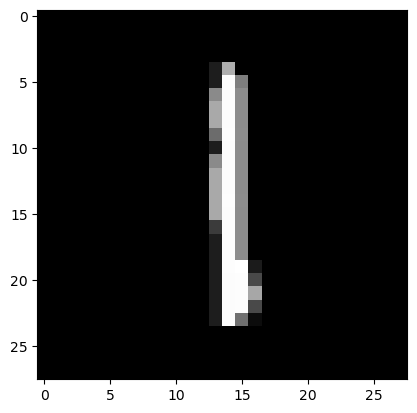

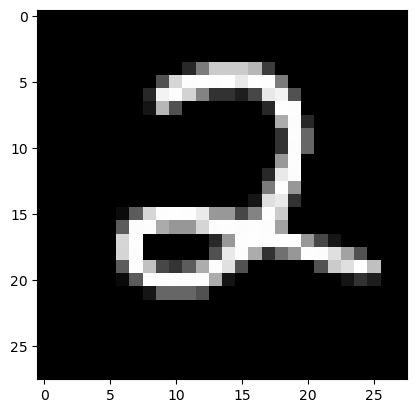

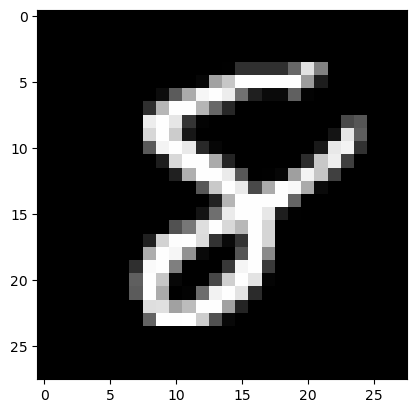

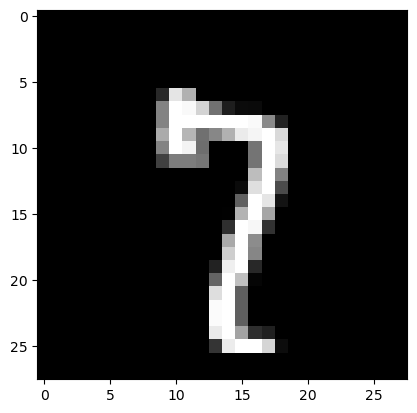

In [20]:
# Here we can see what the examples look like. Note that the feature vector was rescaled to be 28x28
for i in range(4):  
  pyplot.imshow(X_train[i].reshape((28,28)), cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [21]:
# Normalizing the features, so each feature is in the range [-1,1].  
# In this dataset, each feature has a minimum value of 0 and a maximum value of 255.
X_train = 2*X_train/255 -1
X_val = 2*X_val/255-1
X_test = 2*X_test/255-1

### Looking at 4 training examples after scaling

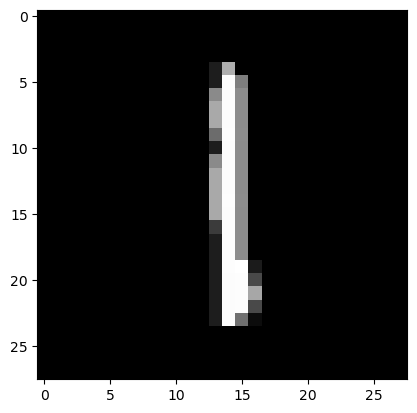

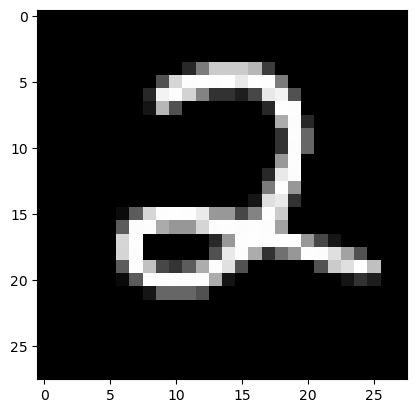

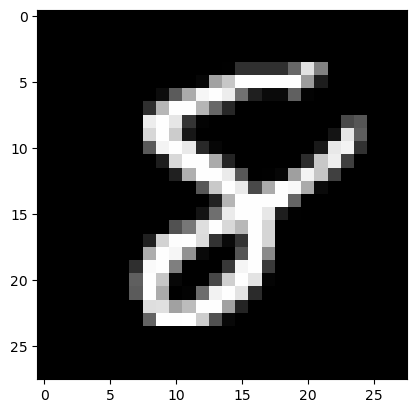

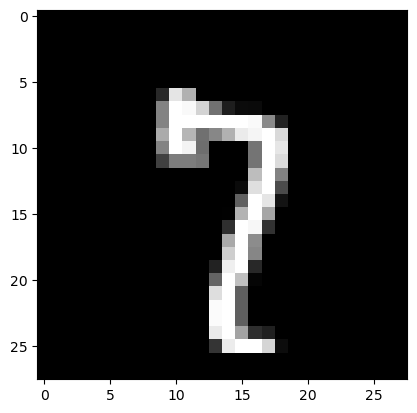

In [22]:
# What the dataset looks like after scaling
for i in range(4):  
  pyplot.imshow(X_train[i].reshape((28,28)), cmap=pyplot.get_cmap('gray'))
  pyplot.show()

# Before writing the Pegasos algorithm, we will write 3 helper functions:

#### A) **Label Encoding:** 
This function will encode the labels for binary classification so that:
* one class has label 1 
* the other class has label -1

#### B) **Dot Product Calculation:** 
This function  computes $X{\bf w}$


#### C) **Objective Function Calculation:** 
This function computes the objective function. During the Pegasos subgradient descent algorithm, we will look at how the function is changing


###  A) Label Encoding

In [23]:
# The original labels are strings: '0','1', '2', ... '9'. Our SVM algorithm Pegasos expects the labels to be encoded as +1 and -1
# Here we encode one digit as 1, and we encode the other 9 digits as -1
def one_vs_rest_encoding(y, digit = '0'):

    # Let y_encoded be an numpy array of encoded digits, with 1 for the digit we want to predict, and -1 for the rest
    # This may take several lines of code, but please store your final encoding in y_encoded
    y_encoded = np.full(y.shape, -1)

    for index in range(len(y)):
        if y[index] == digit:
            y_encoded[index] = 1
    
    return  y_encoded


In [24]:
# Encoding y_train and y_val for '0' vs rest classification
y_train_0_vs_rest = one_vs_rest_encoding(y_train, '0')
y_val_0_vs_rest = one_vs_rest_encoding(y_val, '0')

### B) Dot Product Calculation

* ${\bf w}$ is a d-dimenional coefficient  vector
* $X$ is the design matrix

In [25]:
# Compute the score for each example in X
def score(X, w):
    return np.dot(X,w) 

### C) Objective Function Calculation:  
$\min \lambda/2 \lVert {\bf w}\rVert_2^2 + \sum_{i=1}^N\max(0,1-y^{(i)}({\bf w}^T{\bf x}^{(i)}+w_0)$ where $w_0=0$. 

* ${\bf w}$ is a d-dimenional coefficient  vector
* $X$ is the design matrix
* $\bf y$ is the target vector

In [26]:
def svm_objective(w, X, y, lambda1=.1):
    result = (lambda1 / 2)*(np.linalg.norm(w)**2) + np.sum(np.maximum(0, 1 - y*(np.dot(X,w))))
    return result

Now that we have the helper functions: label encoding, dot product computation, and the objective function, we are ready to write the Pegasos algorithm for binary classification.

# Binary Classification Using the Pegasos algorithm

### Pegasos Binary Classification Algorithm Using Subgradient Descent

The Pegasos algorithm is a binary classification method using subgradient descent. It uses the following:

- `X_train`: The design matrix containing the training data.
- `y_train`: The target vector, consisting of the labels for the training data.
- `lambda1`: A tuning (regularization) parameter in the algorithm, named `lambda1` to avoid conflict with the reserved keyword `lambda` in Python.

The update procedure is as follows:

$
\text{if } y^{(i)}({\bf w}^T{\bf x}^{(i)}\ge 1)  \\
\phantom{abcd} {\bf w} = {\bf w}-\alpha\lambda {\bf w}\\ 
\text{else }  \\
\phantom{abcd} {\bf w} = {\bf w}-\alpha(\lambda {\bf w}-y^{(i)}{\bf x}^{(i)}) 
$

Each updates regularization by slightly decreasing the weight vector's size.
If the functional margin is greater than one, the update compbines the regularization with an adjustment based on the misclassified example.


This update step is applied iteratively to each training example to converge the weights towards an optimal solution for the classification task.


In [27]:
# Here is our stochastic sub-gradient descent
def pegasos(X_train, y_train, lambda1=0.08, num_iters = 3):

    # Hyperparameters: threshold, lambda1
    
    # parameters
    N = X_train.shape[0]
    d = X_train.shape[1]

    t = 0
    # Initial weight vector
    w = np.ones((d,))

    for iter in range(num_iters):
        # Calculate and print the objective value
        print('Iteration %d. J: %.6f' % (iter, svm_objective(w, X_train, y_train)))

        for i in range (N):
            t = t + 1
           
            alpha = 1 / (lambda1 * t) 

            if (y_train[i] * np.dot(X_train[i,:], w)) >= 1:
                w = w - (alpha * lambda1 * w)

            else:
                w = w - alpha *((lambda1 * w) - (y_train[i] * X_train[i,:]))
        
    return w

# Multiclass Classification Using One-Versus-All 

### A) Train 10 binary classifiers using the Pegasos algorithm from the previous question.


In [28]:
# Hyperparameters 
lambda1 = 0.02  # Regularization parameter
num_iters = 4   # Number of iterations


labels = "0123456789"
w_vals= {}
val_scores = {}

for i in range(len(labels)):    
    # Perform one-vs-rest for labels[i]
    y_encoded = one_vs_rest_encoding(y_train, labels[i]) 
    w_vals[i] = pegasos(X_train, y_encoded, lambda1) 
    
    # Using the validation set, estimate accuracy for one-vs-rest classifier for labels[i]
    y_encoded_val = one_vs_rest_encoding(y_val, labels[i]) 
    
    prediction = np.sign(score(X_val, w_vals[i]))
    predicted_correctly = prediction == y_encoded_val

    val_scores[i] = np.mean(predicted_correctly) 

Iteration 0. J: 3063352.125490


Iteration 1. J: 1711.392575
Iteration 2. J: 1577.125200
Iteration 0. J: 4537922.423529
Iteration 1. J: 1663.933534
Iteration 2. J: 1749.673915
Iteration 0. J: 3308132.443137
Iteration 1. J: 3641.624490
Iteration 2. J: 3630.376989
Iteration 0. J: 3450178.231373
Iteration 1. J: 4914.487880
Iteration 2. J: 4930.145345
Iteration 0. J: 3503808.211765
Iteration 1. J: 3499.581766
Iteration 2. J: 3493.074748
Iteration 0. J: 3172322.164706
Iteration 1. J: 5533.166313
Iteration 2. J: 5475.128234
Iteration 0. J: 3414971.800000
Iteration 1. J: 2611.564333
Iteration 2. J: 2556.137162
Iteration 0. J: 3820958.294118
Iteration 1. J: 2791.862932
Iteration 2. J: 2788.233181
Iteration 0. J: 3258690.333333
Iteration 1. J: 6762.534497
Iteration 2. J: 6704.869989
Iteration 0. J: 3570374.168627
Iteration 1. J: 8673.508959
Iteration 2. J: 6121.366536


In [29]:
# Here I check the ratio of correct predictions I have across my binary classifiers
for i in range(len(labels)):
     print(i,": score:", val_scores[i])

0 : score: 0.9903445249067369
1 : score: 0.9899056396752249
2 : score: 0.9795918367346939
3 : score: 0.9710335747202107
4 : score: 0.9760807548825982
5 : score: 0.9642308536317753
6 : score: 0.9855167873601053
7 : score: 0.9826640333552776
8 : score: 0.9576475751590959
9 : score: 0.9615975422427036


### B) Predict labels on the validation set.

In [30]:
predictions = []
for x in X_val:
    scores = [score(x, w_vals[i]) for i in range(len(labels))]
    predicted_label = labels[np.argmax(scores)]
            
    predictions.append(predicted_label) 


### C) Accuracy Estimation on the Validation Set 

In [31]:
eval1 = np.array([1 if predictions[i] == y_val[i] else 0 for i in range(X_val.shape[0])])

accuracy = np.mean(eval1)
print("Accuracy Score:",accuracy)

Accuracy Score: 0.8929120035110818
